In [1]:
from utils import preprocess_2, ClsnaModel_2,visualize_membership
import numpy as np
import torch
from scipy.linalg import orthogonal_procrustes

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

In [3]:
N = 207
DIM = 2
T = 11
SIGMA = 10
TAU = 1
# ALPHA = 1
# DELTA = 2
# GAMMAW = 0.25
# GAMMAB = 0.5

In [4]:
# z,y,Aw,Ab=simulate_clsna(N=N,d=DIM,T=T,alpha=ALPHA,delta=DELTA,sigma=SIGMA, tau=TAU, gammaw=GAMMAW, gammab=GAMMAB)

In [5]:
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import laplacian
Y = np.load("Y.npy")     
membership = np.load("pi.npy")   
membership = 1*(membership!='D')
s = membership
y_t = squareform(Y[:,:,0])
y = [y_t]
Aw = []
Aw2 = []
Ab = []
for i in range(1,T):
    #normalized graph laplalcian by row
    Aw_t = squareform(y_t)*(np.outer(s, s))
    Aw_t = -2*normalize(laplacian(Aw_t), axis=1, norm='l1')
    Aw2_t = squareform(y_t)*(np.outer(1-s, 1-s))
    Aw2_t = -2*normalize(laplacian(Aw2_t), axis=1, norm='l1')
    Ab_t = squareform(y_t)*(np.outer(1-s, s)+np.outer(s, 1-s))
    Ab_t = -2*normalize(laplacian(Ab_t), axis=1, norm='l1')
    y_t = squareform(Y[:,:,i])
    #save
    y.append(y_t)
    Aw.append(Aw_t)
    Aw2.append(Aw2_t)
    Ab.append(Ab_t)

In [6]:
density = []
for network in y:
    density.append(np.mean(network))

In [7]:
density

[0.003283148069977956,
 0.030204962243797196,
 0.06449040851742413,
 0.15449556775010553,
 0.19276769382299141,
 0.24210871910323156,
 0.32198302143426666,
 0.33478729890718073,
 0.3159326485624502,
 0.33117583603020495,
 0.33839876178415645]

In [8]:
np.sum(membership),len(membership)-np.sum(membership)

(77, 130)

In [9]:
# z = np.concatenate(z)
label, persist, Aw, Aw2, Ab, combination_N=preprocess_2(y, Aw, Aw2, Ab, N, T)

In [10]:
_s = torch.arange(0,N*(T-1), requires_grad = False)
ar_pair = torch.stack((_s,_s+N), dim = 1)

In [11]:
combination_N = combination_N.to(device)
label = label.to(device)
persist = persist.to(device)

In [12]:
LR = 5e-3
MOM = 0.99
LR_P = 1e-2

In [13]:
def train(optimizer, index=None, fixed=None):
    t_index=torch.arange(start=0,end=N*T,device=device,requires_grad=False)
    optimizer.zero_grad()
    loss = model.loss(device=device,label=label,persist=persist,sample_edge=combination_N,T_index=t_index,ss=SIGMA,tt=TAU)
    loss.backward()
    model.para.grad = 0.1*((model.para.grad>0).bool().float()-0.5)
    optimizer.step()
    if index is not None:
        with torch.no_grad():
            model.para[index[0],index[1]] = fixed
    return loss.item()

In [14]:
def run(optimizer,index=None,fixed=None):
    for epoch in range(1,12000):
        loss = train(optimizer=optimizer,index=index,fixed=fixed)
        if epoch%1000 == 0:
            print(loss)
    return loss

# Step 1

In [15]:
model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=3).to(device)

In [16]:
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])

In [17]:
run(optimizer)

42533.58394712837
36218.19367093242
33459.75617285636
32331.370659524327
31690.92550948685
31337.745584650955
31240.519371589577
31227.57697669207
31217.753117864755
31213.35712486194
31208.573488294307


31206.90223568298

In [18]:
PCA_p = torch.pca_lowrank(model.z.cpu())[2][:,[0,1]]
init_z = (model.z.cpu().detach()@PCA_p).detach().numpy()
init_para = model.para.detach().cpu().numpy()

# Step 2

In [19]:
# init_z = np.load('../compare/z2_compare.npy')

In [20]:
model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=2).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)

In [21]:
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])

In [22]:
run(optimizer)

34532.15917232409
34187.86041632938
34165.01173266438
34164.90841734977
34164.74653709354
34164.096413581094
34164.03022866015
34163.3980127441
34162.87682314227
34162.435042744444
34162.41851498651


34162.39662783905

In [23]:
init_z = model.z.cpu().detach().numpy()
init_para = model.para.detach().cpu().numpy()

In [24]:
# np.save('../compare/z1.npy', init_z)

In [25]:
init_para

array([[11.99822   ,  2.240929  ],
       [11.99822   ,  0.07500006],
       [-0.18199943,  1.4639851 ],
       [ 0.4059966 , 11.99822   ]], dtype=float32)

In [26]:
np.mean((init_z[:N])**2)**0.5

8.418691511170481

In [27]:
membership = np.load("pi.npy")
membership = membership!='D'

In [28]:
np.where(membership)[0][31]

106

In [29]:
np.argmax((init_z[:N][membership]).sum(axis=1))

75

In [30]:
init_z[:N][membership][31]

array([-16.589893,   7.233452], dtype=float32)

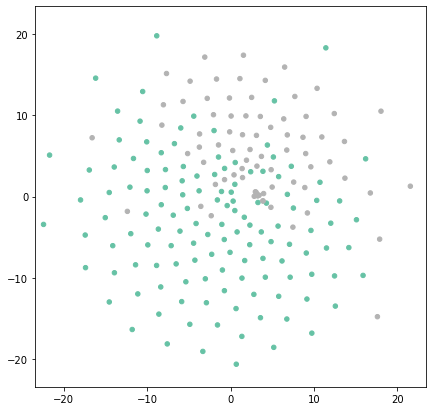

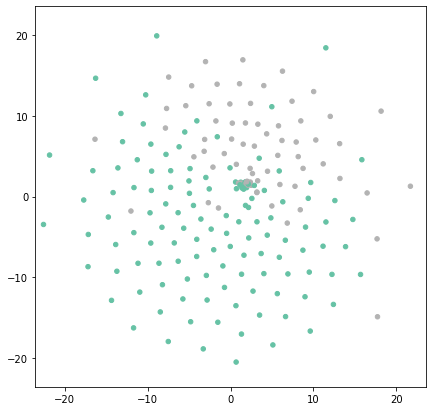

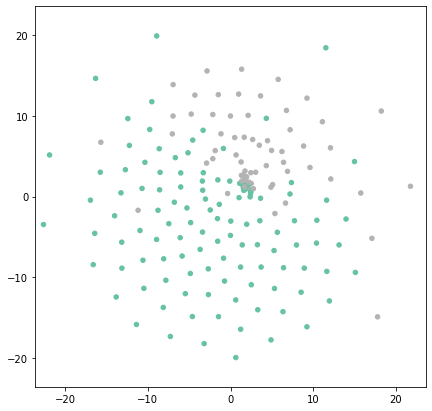

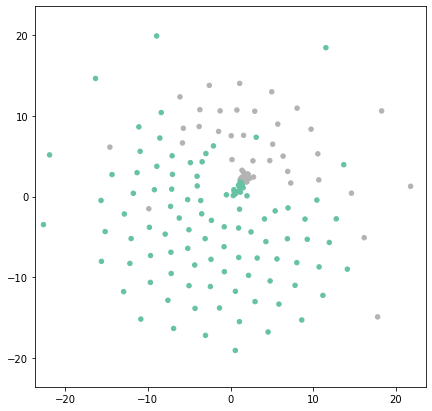

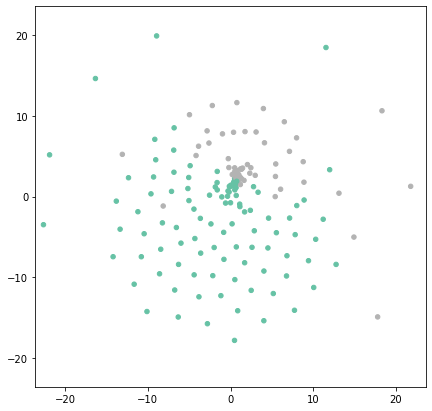

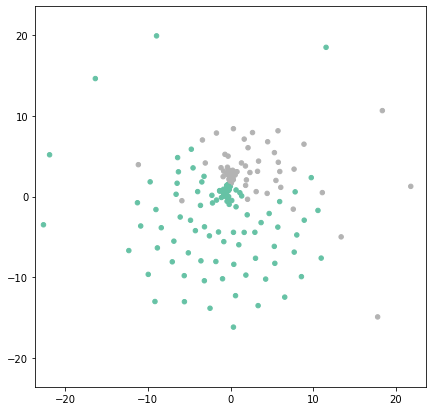

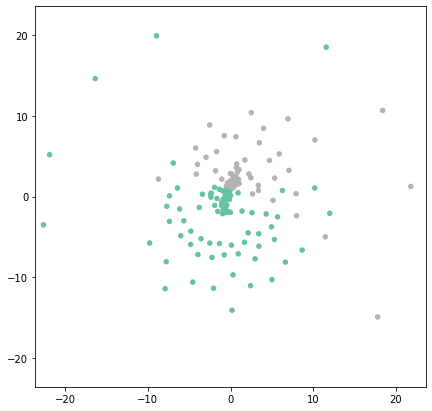

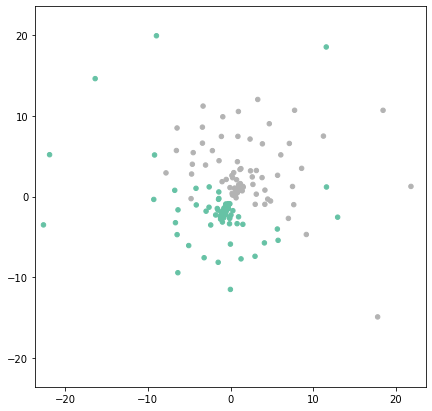

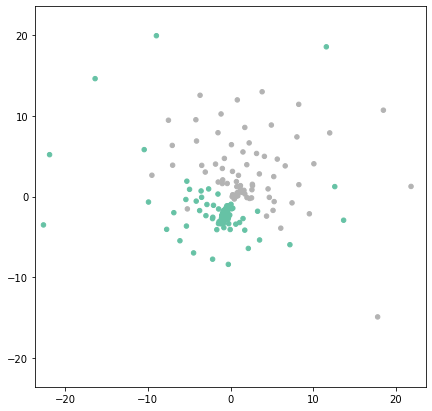

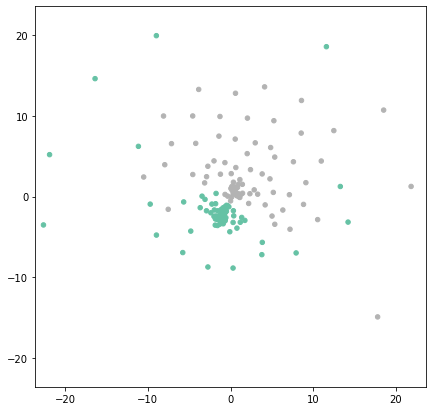

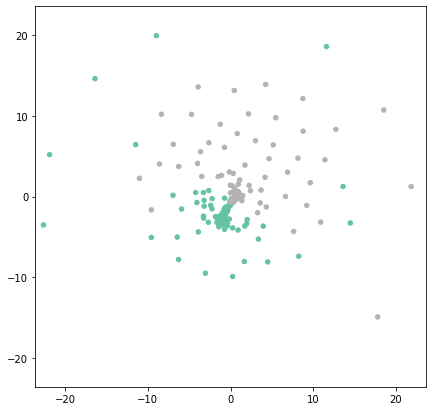

In [31]:
for ti in range(T):
    visualize_membership(z=init_z,membership=np.tile(membership,T),start=ti*N,end=(ti+1)*N)

# Step 3

In [32]:
model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=2).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])    
logL = train(optimizer)

In [33]:
delta_var = 0.1

In [34]:
def run(optimizer,index=None,fixed=None):
    for epoch in range(1,7000):
        loss = train(optimizer=optimizer,index=index,fixed=fixed)
        if epoch%1000 == 0:
            print(loss)
    return loss

In [35]:
parad = {'alpha':(0,1),'delta':(2,1),'gw':(1,1),'gw2':(3,0),'gb':(2,0)}
var_list = []
cov_list = []

for key, value in parad.items():
    model = ClsnaModel_2(device,N,T,ar_pair,Aw,Aw2,Ab,D=2).to(device)
    with torch.no_grad():       
        model.z[:,:] = torch.from_numpy(init_z).to(device)
        model.para[:,:] = torch.from_numpy(init_para).to(device)
    optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])
    newlogL=run(optimizer,value,init_para[value[0],value[1]]+delta_var)
    var_hat = delta_var/(newlogL-logL)**0.5/2**0.5
    var_list.append(round(var_hat,5))
    
    diff = model.para-torch.from_numpy(init_para).to(device)
    extracted_values = [diff[value[0], value[1]].item() for value in parad.values()]
    extracted_values = np.array(extracted_values)
    cov_list.append(extracted_values/delta_var*var_hat**2)

34170.53498334174
34170.50934826612
34170.49787249687
34170.49355332922
34170.49121864943
34170.49043694009
34170.825541718004
34170.808116990986
34170.79970316286
34170.7952071263
34170.79300005203
34170.79189936475
34167.827081925134
34167.811406820125
34167.803341497085
34167.800214280214
34167.798188381435
34167.79737688058
34165.21818790993
34165.16711873249
34165.15541116786
34165.150593866696
34165.14807455161
34165.147222997424
34181.54900661306
34181.52430318404
34181.51024411393
34181.50440809977
34181.50194956273
34181.50062133248


In [36]:
(np.array(cov_list)*10000).round(2)

array([[ 6.180e+00, -2.440e+00, -2.800e-01, -2.200e-01,  1.500e-01],
       [-2.170e+00,  5.960e+00,  5.100e-01,  2.100e-01, -1.500e-01],
       [-4.200e-01,  4.200e-01,  9.260e+00,  5.100e-01, -2.450e+00],
       [-4.500e-01,  2.700e-01,  8.200e-01,  1.817e+01, -1.360e+00],
       [ 1.000e-02, -1.400e-01, -2.130e+00, -6.900e-01,  2.620e+00]])

In [37]:
cov_m = np.array(cov_list)

In [38]:
#gammaw1-gammaw2
(cov_m[2,2]+cov_m[3,3]-cov_m[2,3]-cov_m[3,2])**0.5

0.05109442760579399

In [39]:
#gammaw1-gammab
(cov_m[2,2]+cov_m[4,4]-cov_m[2,4]-cov_m[4,2])**0.5

0.04057454172166129

In [40]:
#gammaw2-gammab
(cov_m[3,3]+cov_m[4,4]-cov_m[3,4]-cov_m[4,3])**0.5

0.04780007946928338

In [41]:
#gammaw1+gammab
(cov_m[2,2]+cov_m[4,4]+cov_m[2,4]+cov_m[4,2])**0.5

0.02699918988381878

In [42]:
#gammaw2+gammab
(cov_m[3,3]+cov_m[4,4]+cov_m[3,4]+cov_m[4,3])**0.5

0.04328415867294693

In [43]:
init_para = init_para.round(3)
printdict = {'a':init_para[0,1],'d':init_para[2,1],'gw':init_para[1,1],'gw2':init_para[3,0],'gb':init_para[2,0]}

In [44]:
cov_list

[array([ 6.17781931e-04, -2.44006409e-04, -2.78002698e-05, -2.16221098e-05,
         1.54443642e-05]),
 array([-2.17387999e-04,  5.95626873e-04,  5.06283747e-05,  2.08466672e-05,
        -1.48904766e-05]),
 array([-4.16622936e-05,  4.16622936e-05,  9.25895799e-04,  5.09236163e-05,
        -2.45359242e-04]),
 array([-4.54330582e-05,  2.72598349e-05,  8.17855983e-05,  1.81745395e-03,
        -1.36307299e-04]),
 array([ 1.30855036e-06, -1.43940540e-05, -2.13309348e-04, -6.93573033e-05,
         2.61729046e-04])]

In [45]:
# for i in range(T-1):
#     d1=zz[N*i:N*(i+1)]
#     d2=zz[N*(i+1):N*(i+2)]
#     c1=d1-(d1.mean(axis=0))[np.newaxis,:]
#     c2=d2-(d2.mean(axis=0))[np.newaxis,:]
#     R,_ = orthogonal_procrustes(c1,c2)
#     print(np.diag(R).round(2))

In [46]:
var_list

[0.02486, 0.02441, 0.03043, 0.04263, 0.01618]

In [47]:
printdict

{'a': 2.241, 'd': 1.464, 'gw': 0.075, 'gw2': 0.406, 'gb': -0.182}

In [48]:
# import csv
# fields=var_list
# with open('var001', 'a') as f:
#     writer = csv.writer(f)
#     writer.writerow(fields)

In [49]:
# import csv
# fields=list(printdict.values())
# with open('theta001', 'a') as f:
#     writer = csv.writer(f)
#     writer.writerow(fields)